In [40]:
# uni_D83AE5_uni (Baseline)
# {"Logloss": 0.03004971105545392, "ROCAUC": 0.978230496019151}
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from scipy.stats import gamma, kstest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    log_loss, 
    roc_auc_score, 
    roc_curve, 
    auc
)
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')  # Use this line to suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

training_data = pd.read_csv('training_data.csv')
training_data = training_data[training_data['BORROWER_ID'] != 'xNullx']
training_data = training_data.sample(frac=1, random_state=42).reset_index(drop=True)
data_submission_example = pd.read_csv('data_submission_example.csv')

In [41]:
training_data.fillna(0, inplace=True)
for col in training_data.columns:
    try:
        training_data[col] = pd.to_numeric(training_data[col], errors='ignore')
    except:
        continue
training_data['TARGET_EVENT_BINARY'] = np.where(training_data['TARGET_EVENT'] == 'K', 1, 0)

In [42]:
lognormal_variables = [
    'CONTRACT_CREDIT_LOSS', 'CONTRACT_DEPT_SERVICE_TO_INCOME',
    'CONTRACT_INCOME', 'CONTRACT_INSTALMENT_AMOUNT', 'CONTRACT_INSTALMENT_AMOUNT_2',
    'CONTRACT_LOAN_AMOUNT', 'CONTRACT_MARKET_VALUE', 'CONTRACT_MORTGAGE_LENDING_VALUE', 
    'CONTRACT_LGD', 'CONTRACT_INCOME'
]
date_variables = ['CONTRACT_DATE_OF_LOAN_AGREEMENT', 'CONTRACT_MATURITY_DATE']

In [43]:
training_data['TARGET_EVENT_DAY'].replace(0.0, np.nan, inplace=True)
training_data['TARGET_EVENT_DAY_JULIAN'] = pd.to_datetime(training_data['TARGET_EVENT_DAY'], origin='julian', unit='D', errors='coerce')
training_data['TARGET_EVENT_DAY_DATETIME'] = pd.to_datetime(training_data['TARGET_EVENT_DAY_JULIAN'],  errors='coerce')

training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'] = pd.to_datetime(training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT'], origin='julian', unit='D')
training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] = pd.to_datetime(training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'],)

training_data['CONTRACT_MATURITY_DATE_JULIAN'] = pd.to_datetime(training_data['CONTRACT_MATURITY_DATE'], origin='julian', unit='D')
training_data['CONTRACT_MATURITY_DATE_DATETIME'] = pd.to_datetime(training_data['CONTRACT_MATURITY_DATE_JULIAN'])

In [44]:
training_data['DAY_DIFF'] = (training_data['TARGET_EVENT_DAY_DATETIME'] - training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME']).dt.days

In [45]:
def create_binary_target_column(dataframe, column_name, event, day_diff_upper_limit):
    dataframe[column_name] = np.where(
        (dataframe['TARGET_EVENT'] == event) & 
        (dataframe['DAY_DIFF'] <= day_diff_upper_limit) & 
        (dataframe['DAY_DIFF'] >= 0), 
        1, 
        0
    )

timeframes = {
    'TARGET_EVENT_BINARY_2Y': 730,
    'TARGET_EVENT_BINARY_1Y': 365,
    'TARGET_EVENT_BINARY_6M': 365//2,
}

for column_name, days in timeframes.items():
    create_binary_target_column(training_data, column_name, 'K', days)


# target_event_binary_columns = []
# for i in range(6):
#     start_day = 273 + i * 30
#     column_header = 'TARGET_EVENT_BINARY_' + str(start_day) + 'D'
#     training_data[column_header] = np.where(
#         (training_data['TARGET_EVENT'] == 'K') & 
#         (training_data['DAY_DIFF'] <= start_day) & 
#         (training_data['DAY_DIFF'] >= 0), 
#         1, 
#         0
#     )
#     target_event_binary_columns.append(column_header)

training_data.drop('DAY_DIFF', axis=1, inplace=True)

In [46]:
print(training_data['TARGET_EVENT_BINARY'].value_counts())
print(training_data['TARGET_EVENT_BINARY_2Y'].value_counts())
print(training_data['TARGET_EVENT_BINARY_1Y'].value_counts())
print(training_data['TARGET_EVENT_BINARY_6M'].value_counts())

TARGET_EVENT_BINARY
0    1590792
1      10871
Name: count, dtype: int64
TARGET_EVENT_BINARY_2Y
0    1591751
1       9912
Name: count, dtype: int64
TARGET_EVENT_BINARY_1Y
0    1596927
1       4736
Name: count, dtype: int64
TARGET_EVENT_BINARY_6M
0    1601267
1        396
Name: count, dtype: int64


In [47]:
numeric_columns = training_data.select_dtypes(include=[np.number]).columns.tolist()
excluded_keywords = ['TARGET', 'event', 'binary', 'DATE']

X_columns = [col for col in numeric_columns if all(keyword.lower() not in col.lower() for keyword in excluded_keywords)]
y_column = 'TARGET_EVENT_BINARY_2Y' 
X_columns

['CONTRACT_CREDIT_INTERMEDIARY',
 'CONTRACT_CREDIT_LOSS',
 'CONTRACT_CURRENCY',
 'CONTRACT_DEPT_SERVICE_TO_INCOME',
 'CONTRACT_INCOME',
 'CONTRACT_INSTALMENT_AMOUNT',
 'CONTRACT_INSTALMENT_AMOUNT_2',
 'CONTRACT_INTEREST_PERIOD',
 'CONTRACT_INTEREST_RATE',
 'CONTRACT_LGD',
 'CONTRACT_LOAN_AMOUNT',
 'CONTRACT_LOAN_CONTRACT_TYPE',
 'CONTRACT_LOAN_TO_VALUE_RATIO',
 'CONTRACT_MARKET_VALUE',
 'CONTRACT_MORTGAGE_LENDING_VALUE',
 'CONTRACT_MORTGAGE_TYPE',
 'CONTRACT_REFINANCED',
 'CONTRACT_RISK_WEIGHTED_ASSETS',
 'CONTRACT_TYPE_OF_INTEREST_REPAYMENT',
 'BORROWER_BIRTH_YEAR',
 'BORROWER_CITIZENSHIP',
 'BORROWER_COUNTRY',
 'BORROWER_COUNTY',
 'BORROWER_TYPE_OF_SETTLEMENT']

In [48]:
# for var in date_variables:
#     training_data[var+ '_JULIAN'] = pd.to_datetime(training_data[var], origin='julian', unit='D')

# training_data['TIME_TO_MATURITY'] = (training_data['CONTRACT_MATURITY_DATE_JULIAN'] - training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN']).dt.days

# year_2018_date = pd.Timestamp('2018-01-01')
# training_data['TIME_TO_MATURITY'] = (training_data['CONTRACT_MATURITY_DATE_JULIAN'] - year_2018_date).dt.days
# training_data['ADJUSTED_TIME_TO_MATURITY'] = training_data['TIME_TO_MATURITY'].apply(lambda x: max(min(730, x),0))

In [49]:
loan_type_dummies = pd.get_dummies(training_data['CONTRACT_LOAN_TYPE'], prefix='LOAN_TYPE', drop_first=True)
frequency_type_dummies = pd.get_dummies(training_data['CONTRACT_FREQUENCY_TYPE'], prefix='FREQ_TYPE', drop_first=True)
training_data = pd.concat([training_data, loan_type_dummies, frequency_type_dummies], axis=1)

X_columns.extend(loan_type_dummies.columns)
X_columns.extend(frequency_type_dummies.columns)

In [50]:
training_data['BORROWER_LOAN_COUNT'] = training_data.groupby('BORROWER_ID')['BORROWER_ID'].transform('count')
training_data['LOAN_BORROWER_COUNT'] = training_data.groupby('CONTRACT_ID')['CONTRACT_ID'].transform('count')
training_data['TOTAL_LOAN_AMOUNT'] = training_data.groupby('BORROWER_ID')['CONTRACT_LOAN_AMOUNT'].transform('sum')
training_data['TOTAL_INSTALLMENT_AMOUNT_1'] = training_data.groupby('BORROWER_ID')['CONTRACT_INSTALMENT_AMOUNT'].transform('sum')
training_data['TOTAL_INSTALLMENT_AMOUNT_2'] = training_data.groupby('BORROWER_ID')['CONTRACT_INSTALMENT_AMOUNT_2'].transform('sum')
training_data['TOTAL_INSTALLMENT_AMOUNT'] = training_data['TOTAL_INSTALLMENT_AMOUNT_1'] + training_data['TOTAL_INSTALLMENT_AMOUNT_2']

X_columns.extend(['BORROWER_LOAN_COUNT', 'TOTAL_LOAN_AMOUNT','TOTAL_INSTALLMENT_AMOUNT','LOAN_BORROWER_COUNT'])
lognormal_variables.extend([ 'TOTAL_LOAN_AMOUNT','TOTAL_INSTALLMENT_AMOUNT'])

In [51]:
threshold = 0.85
correlation_matrix = training_data[X_columns].corr()
highly_correlated_set = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_set.add(colname)

X_columns = [col for col in X_columns if col not in highly_correlated_set]
print('Variables removed:', highly_correlated_set)

Variables removed: {'FREQ_TYPE_2f88e16c', 'CONTRACT_REFINANCED', 'BORROWER_COUNTRY'}


In [74]:
def train_and_predict_two_halves(df, variables, target, model1=LogisticRegression(), scaler=StandardScaler()):
    if lognormal_variables is not None:
        df = df.copy()
        
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var]))*np.sign(df[var])
            else:
                df[var] = np.log1p(df[var])
    df_filtered = df[df['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01']

    X_scaled = scaler.fit_transform(df[variables])
    X_filtered = scaler.transform(df_filtered[variables])

    y = df[target]
    y_filtered = df_filtered[target]
    model1.fit(X_filtered, y_filtered)
    proba = model1.predict_proba(X_scaled)[:, 1]
    return proba

In [53]:
def significant_features(df, variables, target, model1=LogisticRegression(), scaler=StandardScaler()):
    if lognormal_variables is not None:
        df = df.copy()
        
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var]))*np.sign(df[var])
            else:
                df[var] = np.log1p(df[var])

    X_scaled = scaler.fit_transform(df[variables])

    X = sm.add_constant(pd.DataFrame(X_scaled, columns=variables))
    y = df[target]
    model = sm.Logit(y, X).fit()
    print(model.summary())
    p_values = model.pvalues
    non_significant_vars = p_values[p_values > 0.05].index.tolist()

    return model, non_significant_vars

In [54]:
def combined_probability(s):
    if len(s) == 2:
        p_a, p_b = s.values
        return p_a + p_b - p_a * p_b #- (-3.2357827075016176e-05)
    else:
        return 1 - np.prod(1 - s.values)

def create_submission_file(df_preds, target, example, filename='submission.csv', testing=False):
    # Filter the data to only include BORROWER_IDs that are in the submission example
    filtered_training_data = df_preds[df_preds['BORROWER_ID'].isin(example['BORROWER_ID'])]

    # Print warning if the row count is off
    if not testing and len(filtered_training_data) != 1564601:
        print('WARNING: The filtered data does not have the correct number of rows. Make sure you are not using the training data for submission.')
        # raise ValueError('WARNING: The submission file does not have the correct number of rows. Make sure you are not using the training data for submission.')
    # Group by BORROWER_ID and calculate the combined probability

    #######################x########################
    #CUTTING TAILS DID NOT SEEM TO WORK
    #######################x########################
    # filtered_training_data = cut_exponential_tails(filtered_training_data, target)
    grouped_data = filtered_training_data.groupby('BORROWER_ID')[target].apply(combined_probability).reset_index()

    # Create the submission DataFrame
    df_submission = pd.DataFrame()
    df_submission['BORROWER_ID'] = grouped_data['BORROWER_ID']
    df_submission['PRED'] = grouped_data[target]
    print('Before centering:')
    print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())

    print('Centering probabilities...')
    # Center the probabilities around 1.48%
    desired_mean = 0.0148  # 1.48% as a decimal
    while (df_submission['PRED'].max() > 1 or df_submission['PRED'].min() < 0 or abs(df_submission['PRED'].mean() -0.0148) > 0.0005):
        # print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())
        df_submission['PRED'] = df_submission['PRED'].clip(lower=0, upper=1)
        # print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())

        current_mean = df_submission['PRED'].mean()
        adjustment_factor = desired_mean  - current_mean
        df_submission['PRED'] += adjustment_factor
    print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())
    # Save the submission file
    if  not testing and filename is not None:
        df_submission.to_csv(filename, index=False)
    print(f'Saved file: {filename}')
    # if abs(df_submission['PRED'].mean() -0.0148) > 0.0005:
    #    raise ValueError('WARNING: mean is bad')
        
    # Print warning if the row count is off
    if not testing and len(df_submission) != 1117674:
        print('WARNING: The submission file does not have the correct number of rows. Make sure you are not using the training data for submission.')
        # raise ValueError('WARNING: The submission file does not have the correct number of rows. Make sure you are not using the training data for submission.')
        
    return df_submission


In [55]:
def test_model_2y_1y(df, variables, target, model1=LogisticRegression(), model2=LogisticRegression()):
    df = df.copy()
    start_date = pd.Timestamp('2015-01-01')
    end_date = pd.Timestamp('2017-01-01')

    # Mask for rows with CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN between start_date and end_date
    mask_date_range = (df['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'] >= start_date) & (df['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'] <= end_date)

    df = df[mask_date_range]

    probs = train_and_predict_two_halves(
        df, 
        variables, 
        target, 
        model1=model1,
        model2=model2,
    )
    df['2Y-1Y-PROBS'] = probs
    
    test_data = pd.read_csv('./data/1y-test.csv')


    df_submission = create_submission_file(df, '2Y-1Y-PROBS', test_data, filename=None, testing=True)

    merged_df = pd.merge(test_data, df_submission, on='BORROWER_ID')
    true_labels = merged_df['TARGET_EVENT_BINARY_1Y']
    predicted_probs = merged_df['PRED']
    logloss = log_loss(true_labels, predicted_probs)

    print(f'Log loss: {logloss}')
        
    return logloss

In [56]:
model, non_significant_vars = significant_features(training_data, X_columns, y_column,LogisticRegression())

         Current function value: 0.015313
         Iterations: 35
                             Logit Regression Results                             
Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
Model:                              Logit   Df Residuals:                  1601613
Method:                               MLE   Df Model:                           49
Date:                    Mon, 06 Nov 2023   Pseudo R-squ.:                  0.5932
Time:                            14:56:08   Log-Likelihood:                -24526.
converged:                          False   LL-Null:                       -60284.
Covariance Type:                nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                 -10.4383   1765.722     

In [57]:
non_significant_vars

['const',
 'CONTRACT_CREDIT_INTERMEDIARY',
 'CONTRACT_LOAN_AMOUNT',
 'BORROWER_COUNTY',
 'LOAN_TYPE_1f951336',
 'LOAN_TYPE_2f88e16c',
 'LOAN_TYPE_47693941',
 'LOAN_TYPE_5a06241e',
 'LOAN_TYPE_694cbaee',
 'LOAN_TYPE_69f70539',
 'LOAN_TYPE_7e2065f4',
 'LOAN_TYPE_83910425',
 'LOAN_TYPE_8fe006f1',
 'LOAN_TYPE_955ae3ef',
 'LOAN_TYPE_95c4f8fb',
 'LOAN_TYPE_b503a0de',
 'LOAN_TYPE_cde77491',
 'LOAN_TYPE_cf07c2dd',
 'LOAN_TYPE_d3aaffde',
 'LOAN_TYPE_eab72d7a',
 'LOAN_TYPE_f792971b',
 'FREQ_TYPE_89efd382',
 'FREQ_TYPE_bd092d5a']

In [58]:
# X_columns.remove('CONTRACT_CREDIT_INTERMEDIARY')
# X_columns.remove('BORROWER_COUNTY')
# Assuming you have a pandas DataFrame named training_data
# unique_training_data = training_data.drop_duplicates(subset='CONTRACT_ID', keep='first')


In [75]:
# 0.006785876080349979
# Before centering:
# 0.9978858840423693 8.548717289613705e-15 0.006063585227926563
# Centering probabilities...
# 1.0 0.008736424229876956 0.01479999999999999
predicted_probs = 'LOGISTIC_REG'
probs = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    'TARGET_EVENT_BINARY',
    model1=LogisticRegression(max_iter=400, random_state=42),
)
training_data[predicted_probs] = probs
print(probs.mean())


0.011428447568919238


In [60]:
# training_data_joined = training_data.merge(unique_training_data[['CONTRACT_ID', predicted_probs]], 
#                                     on='CONTRACT_ID', 
#                                     how='left')
# training_data_joined

,CONTRACT_ID,BORROWER_ID,CONTRACT_BANK_ID,CONTRACT_CREDIT_INTERMEDIARY,CONTRACT_CREDIT_LOSS,CONTRACT_CURRENCY,CONTRACT_DATE_OF_LOAN_AGREEMENT,CONTRACT_DEPT_SERVICE_TO_INCOME,CONTRACT_FREQUENCY_TYPE,CONTRACT_INCOME,...,FREQ_TYPE_89efd382,FREQ_TYPE_ad534644,FREQ_TYPE_bd092d5a,BORROWER_LOAN_COUNT,LOAN_BORROWER_COUNT,TOTAL_LOAN_AMOUNT,TOTAL_INSTALLMENT_AMOUNT_1,TOTAL_INSTALLMENT_AMOUNT_2,TOTAL_INSTALLMENT_AMOUNT,LOGISTIC_REG
0,MDE1zNJ,PRF52C7u,caa130b5,2.0,359398.0,31,2457709,54.85,479a2e13,372461.0,...,False,False,False,2,3,3319933,0.0,80717.0,80717.0,7.148208e-03
1,1rruIo4,MIYaoPq8,f789f8b0,2.0,3937.0,31,2457904,29.47,479a2e13,223276.0,...,False,False,False,1,2,2533432,0.0,20311.0,20311.0,1.496411e-05
2,xhdrsu5x,0xFcqzYv,c2a40996,2.0,18785.0,31,2457282,81.65,479a2e13,231007.0,...,False,False,False,2,4,7024876,0.0,98662.0,98662.0,2.192721e-04
3,LrUfGq+,Y551bMvC,bd940aa2,1.0,3848.0,31,2457553,8.33,479a2e13,661272.0,...,False,False,False,1,3,7998750,0.0,35616.0,35616.0,5.620013e-05
4,fR2gPfST,A5NUFs2z,1d42bbf5,2.0,0.0,31,2457406,0.00,479a2e13,0.0,...,False,False,False,1,1,120723,0.0,12080.0,12080.0,1.657248e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1601658,XladPB3d,0sMkSY/g,1d42bbf5,1.0,100075.0,31,2458012,30.46,479a2e13,507273.0,...,False,False,False,1,2,5990964,0.0,32582.0,32582.0,7.948178e-04
1601659,q6UqBBI,ww9/NOGp,f789f8b0,2.0,14888.0,31,2457515,27.75,479a2e13,216392.0,...,False,False,False,2,1,1420072,0.0,20080.0,20080.0,3.419202e-04
1601660,hIBR3bvU,MnSjeYaF,533b7c4a,2.0,0.0,31,2457680,0.00,479a2e13,0.0,...,False,False,False,2,1,2453666,0.0,14947.0,14947.0,3.598611e-07
1601661,nUmU4XLo,9cpBKGZ0,caa130b5,1.0,0.0,31,2457345,10.66,479a2e13,173130.0,...,False,False,False,1,1,272804,0.0,17001.0,17001.0,1.162137e-07


In [76]:
submission = create_submission_file(training_data, 'LOGISTIC_REG', data_submission_example, filename='./predictions/logistic-regression-one-model.csv')

Before centering:
0.9999436855807906 5.972999872483342e-14 0.011385118030668709
Centering probabilities...
1.0 0.0034148879087831045 0.014800000000000002
Saved file: ./predictions/logistic-regression-one-model.csv


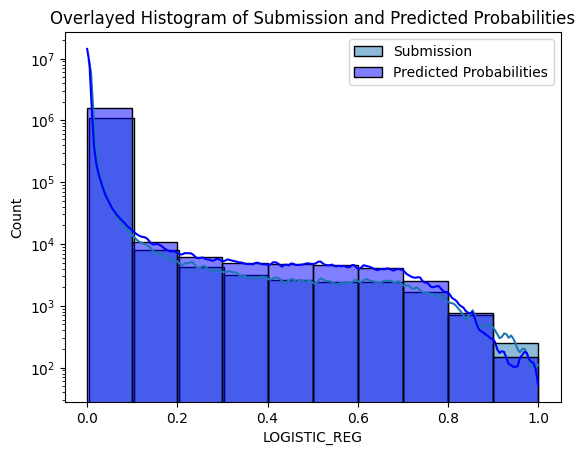

In [77]:
sns.histplot(submission, bins=10, kde=True, label='Submission', alpha=0.5,color='red')
sns.histplot(training_data['LOGISTIC_REG'], bins=10, kde=True, label='Predicted Probabilities', alpha=0.5, color='blue')
plt.yscale('log')
plt.legend()
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')
plt.show()

In [78]:
def calculate_probabilities(data, column, time_factor):
    lambdas = -np.log(1 - data[column]) / time_factor
    probs_2y = 1 - np.exp(-2 * lambdas)
    return probs_2y

In [89]:
magic_number = 1.387
experiment_probs = calculate_probabilities(training_data, 'LOGISTIC_REG', magic_number)
print(experiment_probs.mean(), experiment_probs.max(), experiment_probs.min(), experiment_probs.std())


0.014784419131146103 0.9999992543089721 1.9317880628477724e-14 0.08230974522851488


In [90]:
training_data['EXPERIMENT_PROBS'] = experiment_probs
submission_exp = create_submission_file(training_data, 'EXPERIMENT_PROBS', data_submission_example, filename='./predictions/prediction-with-time-param-0-585.csv')

Before centering:
0.9999992543089721 8.615330671091215e-14 0.014817015618453696
Centering probabilities...
0.9999992543089721 8.615330671091215e-14 0.014817015618453696
Saved file: ./predictions/prediction-with-time-param-0-585.csv


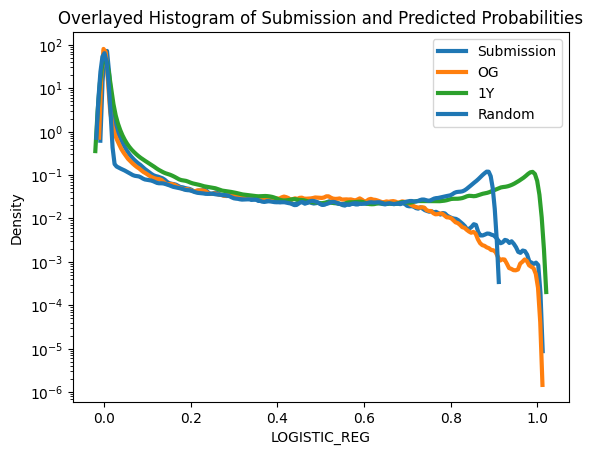

In [80]:
# print(experiment_probs.mean(), experiment_probs.max(), experiment_probs.min(), experiment_probs.std())
sns.kdeplot(submission, label='Submission', lw=3, alpha=1)
sns.kdeplot(training_data['LOGISTIC_REG'], label='OG', lw=3, alpha=1)
sns.kdeplot(experiment_probs, label='1Y', lw=3, alpha=1)
sns.kdeplot(submission_exp, label='Random', lw=3, alpha=1)

plt.yscale('log')
plt.legend()
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')
plt.show()

In [ ]:

logistic_model = LogisticRegression(max_iter=400, C=0.5, random_state=42)
time_periods = {
    '1Y': 1,
    # '18M': 1.5,
    # '9M': 0.75,
    '6M': 0.5
}
for suffix, time_factor in time_periods.items():
    print(f"2Y-{suffix}")
    probs = train_and_predict_two_halves(
        training_data, 
        X_columns, 
        f'TARGET_EVENT_BINARY_{suffix}', 
        model1=logistic_model
    )
    training_data[f'LOGISTIC_REG_{suffix}'] = probs
    training_data[f'{suffix}_PROBA'] = calculate_probabilities(training_data, f'LOGISTIC_REG_{suffix}', time_factor)

In [ ]:
sns.kdeplot(submission, label='Submission', lw=3, alpha=1)
sns.kdeplot(training_data['LOGISTIC_REG'], label='OG', lw=3, alpha=1)
sns.kdeplot(training_data['6M_PROBA'], label='6M', lw=3, alpha=1)
sns.kdeplot(training_data['1Y_PROBA'], label='1Y', lw=3, alpha=1)
sns.kdeplot(training_data['1Y_PROBA']*0.5+training_data['6M_PROBA']*0.5, label='1Y and 6M mix', lw=3, alpha=1)

plt.yscale('log')
plt.legend()
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')
plt.show()

In [ ]:
experiment_probs = calculate_probabilities(training_data, 'LOGISTIC_REG_6M', 0.6376923076923077)
print(experiment_probs.mean(), experiment_probs.max(), experiment_probs.min(), experiment_probs.std())
sns.kdeplot(submission, label='Submission', lw=3, alpha=1)
sns.kdeplot(training_data['LOGISTIC_REG'], label='OG', lw=3, alpha=1)
sns.kdeplot(training_data['6M_PROBA'], label='6M', lw=3, alpha=1)
sns.kdeplot(training_data['1Y_PROBA'], label='1Y', lw=3, alpha=1)
sns.kdeplot(experiment_probs, label='Random', lw=3, alpha=1)

plt.yscale('log')
plt.legend()
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')
plt.show()

In [25]:
# submission_1y_2y = create_submission_file(training_data, '2Y_PROBA', data_submission_example, filename='./predictions/logistic-regression-2y-1y.csv')

Before centering:
0.9999955305137177 1.709743457922741e-14 0.010279658216347512
Centering probabilities...
1.0 0.00452043496900666 0.014800000000000002
Saved file: ./predictions/logistic-regression-2y-1y.csv


In [146]:
for target_day in target_event_binary_columns[:2]:
    probs = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    target_day, 
    model1=LogisticRegression(max_iter=400, C=0.5, random_state=42),
    )
    training_data[target_day+'_PROBS'] = probs
    print(f"Done with {target_day}")

for target_day in target_event_binary_columns[:2]:
    day_str = target_event_binary_columns[0].split('_')[-1].split('D')[0]
    day_int = int(day_str)
    lambdas = -np.log(1 - training_data[target_day+'_PROBS'])/day_int*365
    probs = 1 - np.exp(-2 * lambdas)
    training_data[target_day + '_2Y_LAMBDA'] = lambdas
    training_data[target_day + '_2Y_PROBS'] = probs

Done with TARGET_EVENT_BINARY_273D
Done with TARGET_EVENT_BINARY_303D


In [ ]:
(training_data['TARGET_EVENT_BINARY_273D_PROBS'] == training_data['TARGET_EVENT_BINARY_303D_PROBS']).all()

In [148]:
lambda_columns = [col + '_2Y_LAMBDA' for col in target_event_binary_columns[:2]]
training_data['lambda_std'] = training_data[lambda_columns].std(axis=1)

# Find rows where the standard deviation of the lambdas is not zero
rows_with_nonzero_std = training_data[training_data['lambda_std'] != 0]

# Check if there are any rows with a standard deviation of lambdas that is not zero
any_nonzero_std = not rows_with_nonzero_std.empty

if any_nonzero_std:
    print("There are rows with a non-zero standard deviation of lambdas.")
else:
    print("All rows have a zero standard deviation of lambdas.")

All rows have a zero standard deviation of lambdas.


In [ ]:
first_row_lambdas = [training_data[target_day + '_2Y_LAMBDA'].iloc[0] for target_day in target_event_bindary_columns]
sns.kdeplot(first_row_lambdas, color='viridis')
plt.show()
# a, loc, scale = gamma.fit(first_row_lambdas)
# statistic, pvalue = kstest(first_row_lambdas, 'gamma', args=(a, loc, scale))
# print(f"KS Statistic: {statistic}, P-value: {pvalue}")

In [ ]:
probs = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    y_column, 
    model1=RandomForestClassifier(n_estimators=50, max_depth=3, random_state=42),
)
training_data['RANDOM_FOREST'] = probs

sns.kdeplot(submission, label='Submission', lw=3, alpha=1)
sns.kdeplot(training_data['RANDOM_FOREST'], label='RF', lw=3, alpha=1)
sns.kdeplot(training_data['LOGISTIC_REG'], label='OG', lw=3, alpha=1)
plt.legend()
plt.yscale('log')
plt.legend()
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')
plt.show()

submission_rf = create_submission_file(training_data, 'RANDOM_FOREST',data_submission_example, filename='./predictions/random-forrest-2y-exp-no-multicolinearity-lognormal-time-no-dates.csv')

In [ ]:
probs = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    y_column, 
    model1=xgb.XGBClassifier(max_depth=3, random_state=42, use_label_encoder=False, eval_metric='logloss'),
)
training_data['XGBOOST'] = probs

sns.kdeplot(submission, label='Submission', lw=3, alpha=1)
sns.kdeplot(training_data['XGBOOST'], label='RF', lw=3, alpha=1)
sns.kdeplot(training_data['LOGISTIC_REG'], label='OG', lw=3, alpha=1)
plt.legend()
plt.yscale('log')
plt.legend()
plt.title('Overlayed Histogram of Submission and Predicted Probabilities')
plt.show()

submission_xgb = create_submission_file(training_data, 'XGBOOST',data_submission_example, filename='./predictions/xgb-2y-exp-no-multicolinearity-lognormal-time-no-dates.csv')

Before centering:
0.8675531219873692 0.0026670801246374554 0.008599946438351795
Centering probabilities...
0.8737531755490174 0.008867133686285661 0.014800000000000002
Saved file: ./predictions/random-forrest-2y-exp-no-multicolinearity-lognormal-time-no-dates.csv


In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

models =  [
    (LogisticRegression(max_iter=400, penalty=None, C=1.0, random_state=42),
     LogisticRegression(max_iter=400, penalty=None, C=1.0, random_state=42)),
    
   (LogisticRegression(max_iter=400, penalty=None, C=0.5, random_state=42),
     LogisticRegression(max_iter=400, penalty=None, C=0.5, random_state=42)),
]

best_logloss = 100
best_models = None
for model in models:

    logloss = test_model_2y_1y(
        training_data, 
        X_columns, 
        'TARGET_EVENT_BINARY_1Y',
        model1=model[0],
        model2=model[1],
    )
    if logloss < best_logloss:
        best_logloss = logloss
        best_models = model
    print(model[0])
    print('Logloss is ', logloss)
    print('-----------------------------------------')

c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Evaluation of Model 1 on df2:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    509478
           1       0.60      0.39      0.47      5071

    accuracy                           0.99    514549
   macro avg       0.79      0.69      0.73    514549
weighted avg       0.99      0.99      0.99    514549

Log Loss:
0.020154686217490652
Confusion Matrix:
[[508136   1342]
 [  3093   1978]]
Evaluation of Model 2 on df1:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    509480
           1       0.60      0.40      0.48      5069

    accuracy                           0.99    514549
   macro avg       0.80      0.70      0.74    514549
weighted avg       0.99      0.99      0.99    514549

Log Loss:
0.02041090972095113
Confusion Matrix:
[[508121   1359]
 [  3032   2037]]
Centering probabilities...
1.0 0.0027108450789681583 0.014800000000000004

c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\takat\AppData\Local\Programs\Python

Evaluation of Model 1 on df2:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    509478
           1       0.60      0.39      0.47      5071

    accuracy                           0.99    514549
   macro avg       0.79      0.69      0.73    514549
weighted avg       0.99      0.99      0.99    514549

Log Loss:
0.020154686217490652
Confusion Matrix:
[[508136   1342]
 [  3093   1978]]
Evaluation of Model 2 on df1:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    509480
           1       0.60      0.40      0.48      5069

    accuracy                           0.99    514549
   macro avg       0.80      0.70      0.74    514549
weighted avg       0.99      0.99      0.99    514549

Log Loss:
0.02041090972095113
Confusion Matrix:
[[508121   1359]
 [  3032   2037]]
Centering probabilities...
1.0 0.0027108450789681583 0.014800000000000004

In [ ]:
groups_by_size = {}

# Initialize a dictionary to hold covariance matrices by group size
cov_matrices_by_size = {}

# Group by 'BORROWER_ID' and iterate through the first 100 groups
for idx, (name, group) in enumerate(training_data.groupby('BORROWER_ID')):
    if idx % 100 == 0: 
        print('At index', idx)
        
    if idx == 50000:
        break
    
    # Sort the group by CONTRACT_DATE_OF_LOAN_AGREEMENT
    group = group.sort_values(by='CONTRACT_DATE_OF_LOAN_AGREEMENT')
    
    group_size = len(group)
    if group_size not in groups_by_size:
        groups_by_size[group_size] = []
        
    groups_by_size[group_size].append(group)

# Initialize a new dictionary to hold the merged DataFrames by size
merged_groups_by_size = {}

for size, dfs in groups_by_size.items():
    # Merge all DataFrames of the same size into a single DataFrame
    merged_df = pd.concat(dfs, ignore_index=True)
    # Store the merged DataFrame in the new dictionary
    merged_groups_by_size[size] = merged_df

# Now, merged_groups_by_size contains the merged DataFrames categorized by group size


In [ ]:
import json
import numpy as np
import pandas as pd

# Your code to generate groups_by_size and merged_groups_by_size

cov_matrices_by_size = {}

for size, merged_df in merged_groups_by_size.items():
    if size > 1:  # Covariance matrix for single-element arrays doesn't make sense
        try:
            cov_matrix = np.cov(merged_df['TARGET_EVENT_BINARY'].values.reshape(size,-1))
            if not np.isnan(cov_matrix).any():  # Check for NaN values
                cov_matrices_by_size[size] = cov_matrix.tolist()  # Convert numpy array to list for JSON serialization
        except Exception as e:
            print(f"An error occurred while calculating the covariance matrix for size {size}: {e}")

# Ensure that the dictionary contains only JSON-serializable items
serializable_cov_matrices_by_size = {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in cov_matrices_by_size.items()}

# Save to JSON
with open('./data/cov_matrices_by_size.json', 'w') as f:
    json.dump(serializable_cov_matrices_by_size, f)


C:\Users\takat\AppData\Local\Temp\ipykernel_13332\2391036120.py:12: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov_matrix = np.cov(merged_df['TARGET_EVENT_BINARY'].values.reshape(size,-1))
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [ ]:
cov_matrices_by_size

{2: [[0.005868589752778426, -3.2357827075016176e-05],
  [-3.2357827075016176e-05, 0.005451716043799604]],
 3: [[0.007337144521720125, -2.6009019928111114e-05, -2.6009019928111046e-05],
  [-2.6009019928111114e-05, 0.003507502116019551, -1.2385247584814735e-05],
  [-2.6009019928111046e-05, -1.2385247584814735e-05, 0.003507502116019557]],
 4: [[0.0023364421983921592,
   -1.3695440787761734e-05,
   -5.478176315104693e-06,
   -8.217264472657053e-06],
  [-1.3695440787761734e-05,
   0.005820562334798763,
   -1.3695440787761748e-05,
   -2.054316118164268e-05],
  [-5.478176315104693e-06,
   -1.3695440787761748e-05,
   0.0023364421983921558,
   -8.217264472657026e-06],
  [-8.217264472657053e-06,
   -2.054316118164268e-05,
   -8.217264472657026e-06,
   0.003500554665351909]],
 8: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 

In [ ]:
# Save to JSON
import json

with open('cov_matrices_by_size.json', 'w') as f:
    json.dump(cov_matrices_by_size, f)